In [1]:
!pip install gym[classic_control]
!pip install tqdm
!pip install gym[box2d]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt 
import random
import math
# import progressbar
import time

/home/rahul/.local/lib/python3.6/site-packages/gym/core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [3]:
env_name = "Acrobot-v1"
render_Mode = "human"

In [4]:
def getAngle(cos_val, sin_val):   
    a_acos = math.acos(cos_val)
    angle = 0
    if sin_val < 0:
        angle = math.degrees(-a_acos) % 360
    else: 
        angle = math.degrees(a_acos)
    return angle

In [5]:
def transformObs(obs):
    ang1 = int(getAngle(obs[0], obs[1])/5)
    ang2 = int(getAngle(obs[2], obs[3])/5)
    new_obs = []
    new_obs.append(ang1)
    new_obs.append(ang2)
    new_obs.append(int((obs[4] + 12.57)))
    new_obs.append(int((obs[5] + 28.28)))
    return new_obs

In [6]:
q = [[[[[0 for _ in range(3)] for _ in range(57)] for _ in range(26)] for _ in range(72)] for _ in range(72)]

In [7]:
next_state = [[[[[(-1, -1, -1, -1) for _ in range(3)] for _ in range(57)] for _ in range(26)] for _ in range(72)] for _ in range(72)]

In [8]:
gamma = 0.8
alpha = 0.8

In [9]:
def getAction(obs, epsilon):
    a, b, c, d = int(obs[0]), int(obs[1]), int(obs[2]), int(obs[3]) 
    val = random.uniform(0,1)
    if val <= epsilon:
        return random.randint(0,2)
    else:  
        max_q_val = -20000000
        req_act = 0
        for act in range(0, 3):
            if next_state[a][b][c][d][act] != (-1, -1, -1, -1) and q[a][b][c][d][act] >= max_q_val:
                max_q_val = q[a][b][c][d][act]
                req_act = act
        return req_act 

In [10]:
def performEpisode(epsilon):
    Acrobot = gym.make(env_name)
#     Acrobot = gym.make(env_name, render_mode=render_Mode)
    pre_obs = Acrobot.reset()
    pre_obs = transformObs(pre_obs)
    act = getAction(pre_obs, epsilon)
    done = False
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3]) 
        pre_obs, reward, done, info = Acrobot.step(act)
        pre_obs = transformObs(pre_obs)
        act_next = getAction(pre_obs, epsilon)
        a_n, b_n, c_n, d_n = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        next_state[a][b][c][d][act] = (a_n, b_n, c_n, d_n)
        qmax = 2
        for action in range(3):
            if next_state[a_n][b_n][c_n][d_n][action] != (-1, -1, -1, -1):
                if qmax == 2:
                    qmax = q[a_n][b_n][c_n][d_n][action]
                else:
                    qmax = max(qmax, q[a_n][b_n][c_n][d_n][action])
        if qmax == 2:
            qmax = 0
        q[a][b][c][d][act] = q[a][b][c][d][act] + alpha*(reward + gamma*qmax - q[a][b][c][d][act])
        act = act_next
    Acrobot.close()

In [11]:
def getReward():
    Acrobot = gym.make(env_name)
    pre_obs = Acrobot.reset() 
    pre_obs = transformObs(pre_obs)
    done = False
    tot_reward = 0
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        req_act = getAction(pre_obs, -1)
        pre_obs, reward, done, info = Acrobot.step(req_act)
        tot_reward += reward
        pre_obs = transformObs(pre_obs)   
    Acrobot.close() 
    return tot_reward

In [12]:
x_rew = []
avg_reww = []
orig_reww = []
epsilon_val = 0.1
for cnt in tqdm (range (100000), desc="Loading…", ascii=False, ncols=100):
    performEpisode(epsilon_val)
    if cnt>0 and cnt%1000 == 0:
        rew = 0
        orig_reww.append(getReward())
        for _ in range(200):
            rew += getReward()
        avg_reww.append(rew/200)    
        x_rew.append(cnt/1000)

Loading…:   0%|                                                          | 0/100000 [00:00<?, ?it/s]/home/rahul/.local/lib/python3.6/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/rahul/.local/lib/python3.6/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=

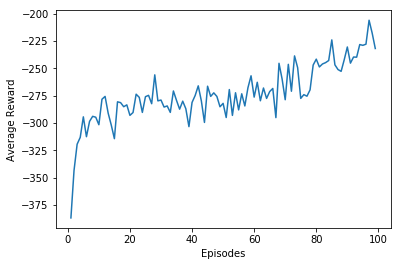

In [13]:
plt.plot(x_rew, avg_reww)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.show()

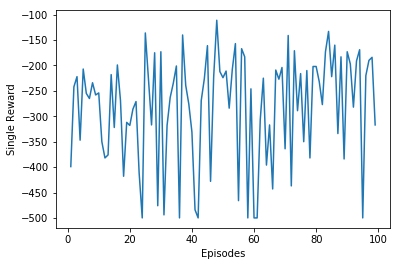

In [14]:
plt.plot(x_rew, orig_reww)
plt.xlabel("Episodes")
plt.ylabel("Single Reward")
plt.show()

In [15]:
Acrobot = gym.make(env_name)
# Acrobot = gym.make(env_name, render_mode=render_Mode)
pre_obs = Acrobot.reset() 
pre_obs = transformObs(pre_obs)
done = False
reward = 0
while not done:
    a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
    act = getAction(pre_obs, -1)
    pre_obs, rew, done, info = Acrobot.step(act)
    pre_obs = transformObs(pre_obs)
    reward += rew
Acrobot.close()    
print(reward) 

-125.0


In [16]:
reward = 0
min_iter = 500
rew_list = []
success = 0
for _ in tqdm (range (1000), desc="Loading…", ascii=False, ncols=100):
    Acrobot = gym.make(env_name)
    #Acrobot = gym.make(env_name, render_mode=render_Mode)
    pre_obs = Acrobot.reset() 
    pre_obs = transformObs(pre_obs)
    done = False
    cur = 0
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        act = getAction(pre_obs, -1)
        pre_obs, rew, done, info = Acrobot.step(act)
        pre_obs = transformObs(pre_obs)
        cur += rew
    reward += cur  
    if cur > -500:
        success += 1
    min_iter = min(min_iter, -cur)
    rew_list.append(cur)
    Acrobot.close()
rew_list.sort(reverse=True)   
print("Average reward:", reward/1000) 
print("Highest Reward:", -min_iter)
print("Success Rate:", success/1000)
print(rew_list[:50])

Loading…: 100%|█████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.42it/s]

Average reward: -240.319
Highest Reward: -101.0
Success Rate: 0.975
[-101.0, -101.0, -102.0, -107.0, -109.0, -110.0, -115.0, -115.0, -115.0, -116.0, -116.0, -116.0, -117.0, -119.0, -120.0, -120.0, -120.0, -121.0, -121.0, -121.0, -122.0, -122.0, -123.0, -124.0, -124.0, -125.0, -127.0, -127.0, -127.0, -128.0, -128.0, -129.0, -129.0, -129.0, -129.0, -129.0, -130.0, -130.0, -130.0, -130.0, -130.0, -131.0, -131.0, -132.0, -132.0, -133.0, -133.0, -133.0, -134.0, -134.0]


In [17]:
reward = 0
min_iter = 500
rew_list = []
success = 0
for _ in tqdm (range (100), desc="Loading…", ascii=False, ncols=100):
    Acrobot = gym.make(env_name)
    #Acrobot = gym.make(env_name, render_mode=render_Mode)
    pre_obs = Acrobot.reset() 
    pre_obs = transformObs(pre_obs)
    done = False
    cur = 0
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        act = getAction(pre_obs, -1)
        pre_obs, rew, done, info = Acrobot.step(act)
        pre_obs = transformObs(pre_obs)
        cur += rew
    reward += cur  
    if cur > -500:
        success += 1
    min_iter = min(min_iter, -cur)
    rew_list.append(cur)
    Acrobot.close()
rew_list.sort(reverse=True)   
print("Average reward:", reward/100) 
print("Highest Reward:", -min_iter)
print("Success Rate:", success/100)
print(rew_list[:50])

Loading…: 100%|███████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.24it/s]

Average reward: -233.34
Highest Reward: -82.0
Success Rate: 0.99
[-82.0, -112.0, -114.0, -119.0, -120.0, -125.0, -129.0, -130.0, -132.0, -133.0, -135.0, -139.0, -140.0, -144.0, -149.0, -149.0, -152.0, -158.0, -158.0, -163.0, -164.0, -167.0, -167.0, -167.0, -168.0, -170.0, -171.0, -173.0, -174.0, -179.0, -179.0, -181.0, -183.0, -187.0, -191.0, -191.0, -191.0, -192.0, -194.0, -194.0, -197.0, -198.0, -199.0, -199.0, -200.0, -203.0, -203.0, -205.0, -208.0, -211.0]


In [20]:
reward = 0
min_iter = 500
rew_list = []
success = 0
for _ in tqdm (range (15), desc="Loading…", ascii=False, ncols=100):
    #Acrobot = gym.make(env_name)
    Acrobot = gym.make(env_name, render_mode=render_Mode)
    pre_obs = Acrobot.reset() 
    pre_obs = transformObs(pre_obs)
    done = False
    cur = 0
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        act = getAction(pre_obs, -1)
        pre_obs, rew, done, info = Acrobot.step(act)
        pre_obs = transformObs(pre_obs)
        cur += rew
    reward += cur  
    if cur > -500:
        success += 1
    min_iter = min(min_iter, -cur)
    rew_list.append(cur)
    Acrobot.close()
rew_list.sort(reverse=True)   
print("Average reward:", reward/15) 
print("Highest Reward:", -min_iter)
print("Success Rate:", success/15)
print(rew_list)

Loading…: 100%|█████████████████████████████████████████████████████| 15/15 [04:15<00:00, 17.06s/it]

Average reward: -253.33333333333334
Highest Reward: -123.0
Success Rate: 1.0
[-123.0, -147.0, -151.0, -187.0, -204.0, -208.0, -225.0, -236.0, -266.0, -290.0, -291.0, -341.0, -359.0, -374.0, -398.0]
